# Import

In [1]:
import xarray as xr
import seaborn as sns
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Constants

In [42]:
interp_lev =  [10,30,70,100]
sel_dict = dict(lat = slice(-20,20), time = slice('1991-09','1991-11'))

# Functions

In [72]:
def difference(control, pert):
    c = control.sel(**sel_dict).interp(lev = interp_lev).mean(['ens'])
    p = pert.sel(**sel_dict).interp(lev = interp_lev).mean(['ens'])
    diff = p-c
    return diff

def process_echam(ds):
    ds = ds.sortby('lat')
    ds = ds.rename({'plev': 'lev', 'st': 'T'})
    ds['lev'] = ds.lev.values/100.
    ds['lev'].attrs['units'] = 'hPa'
    return ds

def process_salsa(ds):
    ds = ds.sortby('lat')
    ds = ds.rename({'plev': 'lev', 'ta': 'T'})
    ds['lev'] = ds.lev.values/100.
    ds['lev'].attrs['units'] = 'hPa'
    return ds

In [4]:
from dask.distributed import Client

client = Client()
client

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computa

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 9
Total threads: 54,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43851,Workers: 9
Dashboard: http://127.0.0.1:8787/status,Total threads: 54
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:41319,Total threads: 6
Dashboard: http://127.0.0.1:36035/status,Memory: 11.11 GiB
Nanny: tcp://127.0.0.1:41133,


# Model processing

In [77]:
ls_all = []
model = 'ECHAM-SALSA'


scen = 'Em_Ism'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*ta_199101-199512_pl.nc'))
ds_p = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
).pipe(process_salsa)

scen = 'Cntrol'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*ta_199101-199512_pl.nc'))
ds_c = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
).pipe(process_salsa)

diff = difference(ds_c[sel_var], ds_p[sel_var]).load()
df = diff.to_dataframe().reset_index().drop(columns=['lat', 'lon', 'time'])
df['model'] = df.shape[0]*[model]
ls_all.append(df)

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [78]:
model = 'ECHAM'
sel_var = 'T'

scen = 'Em_Ism'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*meteo_monavgs1991_1995_pl.nc'))
ds_p = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
).pipe(process_echam)

scen = 'Cntrol'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*meteo_monavgs1991_1995_pl.nc'))
ds_c = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
).pipe(process_echam)

diff = difference(ds_c[sel_var], ds_p[sel_var]).load()
df = diff.to_dataframe().reset_index().drop(columns=['lat', 'lon', 'time'])
df['model'] = df.shape[0]*[model]
ls_all.append(df)

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [79]:
model = 'WACCM6CARMA'

scen = 'Em_Ism'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*h0.T.*.nc'))
ds_p = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
)

scen = 'Cntrol'
root_path = Path(f'/work/bm0885/HErSEA/HErSEA_Pin/{scen}/')
model_path = root_path / model
infiles = sorted(model_path.glob('**/*h0.T.*.nc'))
ds_c = xr.open_mfdataset(
    infiles,
    concat_dim = 'ens',
    parallel = True,    
    combine='nested'
)
ds_c

diff = difference(ds_c['T'], ds_p['T']).load()
df = diff.to_dataframe().reset_index().drop(columns=['lat', 'lon', 'time'])
df['model'] = df.shape[0]*[model]
ls_all.append(df)

HDF5-DIAG: Error detected in HDF5 (1.12.2) HDF5-DIAG: Error detected in HDF5 (1.12.2) HDF5-DIAG: Error detected in HDF5 (1.12.2) thread 0:
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
    minor: Can't open object
  #001: H5VLcallback.c line 1091 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
thread 0  #002: H5VLcallback.c line 1058 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
:
  #003: H5VLnative_attr.c line 130 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
thread 0    minor: Can't open object
  #000: H5A.c line 528 in H5Aopen_by_name(): can't open attribute
    major: Attribute
  #004: H5Aint.c line 545 in H5A__open_by_name(): unable to load attribute info from object header
:
    minor: Can't open object
    major: Attribute
    minor: Unable to initialize object
  #001: H5VLcallback.c line 1091 in H5VL

# Visualization

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/seaborn/_o

Text(0.5, -0.1, 'temperature anomaly [K]')

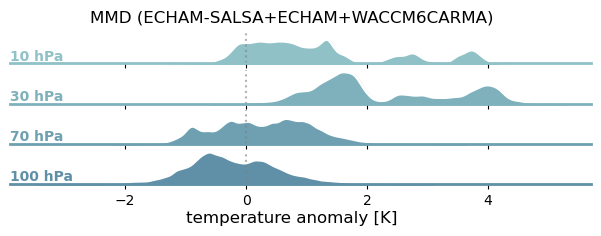

In [99]:
# Initialize the FacetGrid object
df_all = pd.concat(ls_all)
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df_all, row="lev", hue="lev", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "T",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "T", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axvline, ls = 'dotted', color = 'gray', alpha = 0.6)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label+' hPa', fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "T")
# Set the subplots to overlap
#g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel = "")
g.despine(bottom=True, left=True)
g.fig.suptitle('MMD ('+'+'.join(df_all.model.unique())+')')
g.fig.supxlabel('temperature anomaly [K]', y = -0.1)